# Camera Calibration
## Computer Vision and Image Processing - Lab Session 3
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it

**Camera calibration** is the process whereby all **parameters** defining the camera model are estimated for a specific camera device.

The **pinhole camera model** is represented by the **Perspective Projection Matrix (PPM)**, which in turn can be decomposed into 3 independent tokens: **intrinsic parameter matrix ($A$), rotation matrix ($R$) and translation vector ($T$)**. Depending on the application, either the PPM only or also its independent components ($A, R, T$) need to be estimated.

Many camera calibration algorithms do exist. The basic process, though, relies always on setting up a linear system of equations given a set of **known 3D-2D correspondences**, so as to then solve for the unknown camera parameters.

To obtain the required correspondences specific physical objects (referred to as **calibration targets**) having easily detectable features (such as e.g. **chessboard** or dot patterns) are typically deployed.

## Pinhole camera model

The general form of the Perspective Projection Matrix  (PPM or P) can be thought of as encoding the position of the camera wrt the world into G, the perspective projection carried out by a pinhole camera into the canonical $PPM [I|0]$ and, finally, the actual characteristics of the sensing device into $A$.

<p style="text-align: center"> $A[I│0]G$ or $P=A[R│T]$ </p>

<img src="LabSession3Images/ppm.png" width="256" height="128">


## Intrisics Parameters

Matrix A, which models the characteristics of the image sensing device, is called **Intrinsic Parameter Matrix**. 

<img src="LabSession3Images/intrisics.png" width=256>

where:

* $f$ is the **focal length** of the pinhole system
* $k_u = \frac{1}{\delta u}$ , $ k_v = \frac{1}{\delta v} $ are, respectively, the inverse of the **horizontal and vertical pixel size**
* $u_0$, $v_0$ are the coordinates of the **piercing point** wrt the top-left corner

**Intrinsic parameters are 5** but can be **reduced** in number by setting $a_u = f*k_u$, $ a_v = f*k_v$ such quantities representing, respectively, the focal length expressed in horizontal and vertical pixel size. 

**The number of intrinsic parameters estimated by OpenCV is thus 4**. The pixel size is usually provided in the camera datasheet: if it is known, the metric focal length can be recovered.

## World Reference Frame

The **World Reference Frame**, to ease the derivation and implementation of calibration routines, is assumed **attached with the chessboard**. Therefore, **different calibration images lead to different World Reference Frames**.
In other words, you can actually doing your calibration by **moving the chessboard** (as depicted on the left picture), but the software sees those transformations as if you were **moving the camera** (as depicted on the right picture).

<img src="LabSession3Images/wrf.png" width="768">

Of course you can also move the camera to acquire the various calibration images.

The position of the WRF on the chessboard is arbitrary, and different packages define it differently.

If we are using an **unambiguous chessboard**, the WRF can at least be defined univocally.

For instance, OpenCV > 2.2 places it so that:
* the **origin** lays on the **first row or column starting and ending with black squares**
* the resulting **z axis** in a **right-handed** reference frame **points away from the camera**.

We can find two possible origins in the unambiguous pattern below (red and yellow points):

<img src="LabSession3Images/ambiguos_pattern.png" width="512">

**We have to know the chessboard width and height**.

Depending on what we choose as origin the chessboard can be specified to the software as 8(width) times 5(height) squares, or viceversa as depticted in the image below. 

Choosen the width and height of the pattern and given that the z axis has to form a right handed reference frame with the others, for each origin we obtain only one possibile direction of x and y axis.

The **x and y axes direction** are **fixed by the chessboard definition**.
* **x axis** lays along the **“width”** of the chessboard
* **y axis** along the **“height”** of the chessboard

<img src="LabSession3Images/wrf_chessboard.png" width="512">

Note that, in OpenCV to define the chessboard we use **the number of internal corners**.

Camera calibration approaches can be split into **two** main categories:

* Those relying on a **single image** featuring **several (at least  2) planes containing a known pattern**. 

<img src="LabSession3Images/singlepattern.png" width="256" height="128">

* Those relying on **several (at least 3) different images** of **one given planar pattern**. 

<img src="LabSession3Images/patterns.png" height="256">

In practise, it is difficult to build accurate targets containing multiple planes, while an accurate planar target can be attained rather easily. 

Implementing a camera calibration software requires a significant effort. However, the main Computer Vision toolbox include specific functions (OpenCV, Matlab CC Toolbox, Halcon.) 

## Zhang Method for Calibration
<img src="LabSession3Images/zhang.png" width="256">

## Implementing **Camera Calibration** with *OpenCV*

First of all let us import the usual libraries:

In [71]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Acquiring the calibration images

The **minimum** number of images to calibrate a camera is __3__. A rule of thumb is to take **at least 12** pictures because it is possible that you will not be able to detect the chessboard in all of them and it will make calibration results more robusts.

Moreover, try to take both pictures with **several rotations of the chessboard**.

When you acquired the pictures save them on your computer in a known folder.

Let us create a list of the paths to all the calibration images. (**The path to the images you have just taken if you want to calibrate your own camera** or you can use the pictures contained inside *"calibration/chessboards"*).

In [75]:
dirname = "calibration/chessboards/"
img_names = [dirname + str(i) + ".jpg" for i in range(13)]
print(img_names)

['calibration/chessboards/0.jpg', 'calibration/chessboards/1.jpg', 'calibration/chessboards/2.jpg', 'calibration/chessboards/3.jpg', 'calibration/chessboards/4.jpg', 'calibration/chessboards/5.jpg', 'calibration/chessboards/6.jpg', 'calibration/chessboards/7.jpg', 'calibration/chessboards/8.jpg', 'calibration/chessboards/9.jpg', 'calibration/chessboards/10.jpg', 'calibration/chessboards/11.jpg', 'calibration/chessboards/12.jpg']


## Finding 2D-3D correspondeces

First of all we need to perform the first step of Zhang method. Finding all 2D-3D correspondeces between corner 2D position in the image and 3D world coordinates.

<img src="LabSession3Images/zhang_1.png" width="256">

### 3D Coordinates

We need to measure the size of the square (measure it direcly using a ruler on the printed chessboard) to know the 3D coordinates of the points:

In [73]:
square_size = 26.5 #mm

Then count the number of **inner corner** per row and column of the calibration target (chessboard). We will call it *pattern_size*:

In [ ]:
pattern_size = (9,6) # number of inner corner

Let us create the 3D coordinate for each corner of the chessboard. 

We know that 3D coordinates of a corner $c_{i,j}$ will be *i x square_size* and *j x square_size* where $i,j$ are the row and column of the corner in the pattern grid. 

The total number of corner is *rows x columns* of the pattern size.

To build the $i,j$ coordinate for each point in the grid is really useful the numpy method *np.indices(shape)* which returns an rows x columns array containing the 2D indices of that array:

In [76]:
indices = np.indices(pattern_size, dtype=np.float32)
print("Shape of indices: " , indices.shape)
print(indices)

Shape of indices:  (2, 9, 6)
[[[0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 1. 1.]
  [2. 2. 2. 2. 2. 2.]
  [3. 3. 3. 3. 3. 3.]
  [4. 4. 4. 4. 4. 4.]
  [5. 5. 5. 5. 5. 5.]
  [6. 6. 6. 6. 6. 6.]
  [7. 7. 7. 7. 7. 7.]
  [8. 8. 8. 8. 8. 8.]]

 [[0. 1. 2. 3. 4. 5.]
  [0. 1. 2. 3. 4. 5.]
  [0. 1. 2. 3. 4. 5.]
  [0. 1. 2. 3. 4. 5.]
  [0. 1. 2. 3. 4. 5.]
  [0. 1. 2. 3. 4. 5.]
  [0. 1. 2. 3. 4. 5.]
  [0. 1. 2. 3. 4. 5.]
  [0. 1. 2. 3. 4. 5.]]]


**N.B** we need it in **float** type because later we will need to multiply it with float numbers.

Let us see for instance the x and y indices of the position 1,1 in the grid:

In [77]:
print(indices[:,1,1])

[1. 1.]


(1,1) of course!

Since we know that the distance between the corners is exactly 26.5mm (square_size), we have to multiply these indices by square_size to get the real 3D x,y coordinates:

In [78]:
indices *= square_size
print(indices)

[[[  0.    0.    0.    0.    0.    0. ]
  [ 26.5  26.5  26.5  26.5  26.5  26.5]
  [ 53.   53.   53.   53.   53.   53. ]
  [ 79.5  79.5  79.5  79.5  79.5  79.5]
  [106.  106.  106.  106.  106.  106. ]
  [132.5 132.5 132.5 132.5 132.5 132.5]
  [159.  159.  159.  159.  159.  159. ]
  [185.5 185.5 185.5 185.5 185.5 185.5]
  [212.  212.  212.  212.  212.  212. ]]

 [[  0.   26.5  53.   79.5 106.  132.5]
  [  0.   26.5  53.   79.5 106.  132.5]
  [  0.   26.5  53.   79.5 106.  132.5]
  [  0.   26.5  53.   79.5 106.  132.5]
  [  0.   26.5  53.   79.5 106.  132.5]
  [  0.   26.5  53.   79.5 106.  132.5]
  [  0.   26.5  53.   79.5 106.  132.5]
  [  0.   26.5  53.   79.5 106.  132.5]
  [  0.   26.5  53.   79.5 106.  132.5]]]


We got the x,y coordinates of each corner in the world reference system ! (assumed that the first is in position (0mm,0mm)). For instance let us try to plot again the 1,1 corner position:

In [79]:
print(indices[:,1,1])

[26.5 26.5]


The corner $c_{1,1}$ is in position 26.5,26.5 mm in the world! Moreover, during the camera calibration we assume that all the pixels belonging to the chessboard lie in the same plane with z=0.

So the 3D coordinate in the WRF of each corner is just x,y,0!

Let us create an array for containing each 3D cordinate. It will have shape *rows x columns x 3*  where rows and columns are referred to the pattern size while 3 is because we need x,y,z values.

In [80]:
pattern_points = np.zeros([pattern_size[0]*pattern_size[1], 3], np.float32)
print(pattern_points.shape)

(54, 3)


Now let us assing each x,y to pattern_points. We need to transpose the (__2__,9,6) to become a (6,9,**2**) array and then reshape it to (54,2). Then we assign this vector to the pattern_points[:,:2] getting our array of (x,y,0) 3D coordinates:

In [88]:
coords_3D = indices.T
print("Transpose shape: " , coords_3D.shape)

coords_3D = coords_3D.reshape(-1, 2)
print(coords_3D.shape)

pattern_points[:, :2] = coords_3D

# The croner [0,1] of the grid will be in posizion 1
print("3D coordinates of Corner [0,1]: ",  pattern_points[1])

# The croner [1,1] of the grid will be in posizion 9+1=10 where 9 is pattern_size[0] (width)
print("3D coordinates of Corner [1,1]: ",  pattern_points[pattern_size[0]*1 + 1])

Transpose shape:  (6, 9, 2)
(54, 2)
3D coordinates of Corner [0,1]:  [26.5  0.   0. ]
3D coordinates of Corner [1,1]:  [26.5 26.5  0. ]


### 2D Coordinates

Now that we have the 3D coordinate of each corner in the world reference system we need to get the cooresponding 2D coordinate of each corner in each chessboard images. 

Let us first load a sample image to understand how to detect corners. It needs to be loaded **GRAYSCALE**:

In [89]:
img = cv2.imread("calibration/chessboards/0.jpg",cv2.IMREAD_GRAYSCALE)

We can use **cv2.findChessboardCorners(img, pattern_size)** to detect corner in an image. 

The functions will return a boolean value **found** and the list of the **corners** 2D coordinate in the image. **found** will be true if and only if all the 9x6 (54) corners will be detected in the image. If the image is too dark or too bright the algorithm may fail to detect corners and **found** would be false. 

**N.B** If you pass the wrong pattern_size the method will be really slow leading to a **found=False** result.

In [ ]:
found, corners = cv2.findChessboardCorners(img, pattern_size)
print("Found: " , found)
print("2D image coordinate of corners: ", corners)

Even if we **found** the 2D positions of corners, they might not be accurate. 

To refine the results we can call **cv2.cornerSubPix**. 

See in OpenCV [documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornersubpix#cornersubpix*documentation.) for more detail about this function.

In [90]:
# Do cornerSubPix only if chessboard found is True
if found:
    #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    #Image Corners 
    cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

Let us visualize the founded corners. Follow **from red to blu** lines to go from (0,0) to (9,6) corner:

In [ ]:
vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawChessboardCorners(vis, pattern_size, corners, found)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

When we calibrate a camera we need to repeat this operation on all calibration images so I will define a function to process images which return the pairs of (2D,3D) points:

In [ ]:
def processImage(fn):
    print('processing {}'.format(fn))
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print("Failed to load", fn)
        return None

    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        #Image Corners 
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawChessboardCorners(vis, pattern_size, corners, found)
    
    plt.figure(figsize=(20,10))
    plt.imshow(vis)
    plt.show()
    
    if not found:
        print('chessboard not found')
        return None

    print('           %s... OK' % fn)
    return (corners.reshape(-1, 2), pattern_points)

We then process each chessboard image we acquired previously:

In [ ]:
chessboards = [processImage(fn) for fn in img_names]

And we filter out each not found chessboard:

In [ ]:
chessboards = [x for x in chessboards if x is not None]

We add to two lists each 2D and 3D points respectively building the set of 2D-3D correspondeces used during calibration process:

In [ ]:
# Creating the lists of 2D and 3D points 
obj_points = [] #3D points
img_points = [] #2D points

for (corners, pattern_points) in chessboards:
        img_points.append(corners)
        obj_points.append(pattern_points)

## Calibrate Camera

Now that we got all 3D points (obj_points) and their corresponding 2D points (img_points) we can calibrate our camera and perform all other Zhang steps:
    
<img src="LabSession3Images/zhang_all.png" width="256">

**READY ???????**

...

...

...

...

...

...

...

...

...

...

...

...

**LUCKY** OpenCV provides a single method to it! (Danger Escaped! :D )

**cv2.calibrateCamera(3D_points, 2D_points, (width,height), None,None)**

This method takes as input the corresponding points and the width and height of the image and it returns all the parameters of the camera:

In [ ]:
# Getting the width and height of the images
h, w = cv2.imread(img_names[0], cv2.IMREAD_GRAYSCALE).shape[:2]

# Calibrating Camera
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())
print("Rotation vectors:", rvecs)
print("translation vectors", tvecs)

We notice that we got several outputs from *cv2.calibrateCamera*. They are respectively:
* RMS (Root Mean Square Error): **Reprojection error in pixel** using the estimated camera parameters. The lower it is the better calibration you obtain. Usually it should be in a range **between 0.1 and 1** in good calibrations. If it is much larger than 1 you did some mistakes during the calibration process.

* camera_matrix: **Intrinsics parameters** of the camera expressed as 3x3 matrix

* dist_coefs: **lens distorsion** coefficents expressed as 1x6 array.

* rvecs: **rotations** of the cameras **for each chessboard image**. It is an array of dimension Nx3 where N are the number of images where you found the chessboard during calibration while 3 are the 3 DOF of the rotations.

* tvecs: **translations** of the cameras **for each chessboard image**. It is an array of dimension Nx3 where N are the number of images where you found the chessboard during calibration while 3 are the coordiante of the 3D translation vectors.

**N.B** If we need the rotation matrix starting from a rotation vector rvec or vice-versa we can use:

**cv2.Rodrigues(rvec,tvec)**.

Given a rvec it will return the 3x3 rotation matrix. Let us try with the first element of rvecs found by calibration:

In [92]:
rotation_matrix = cv2.Rodrigues(rvecs[0],tvecs[0])[0]
print("R shape: ", rotation_matrix.shape)
print(rotation_matrix)

R shape:  (3, 3)
[[-0.04983416 -0.96518808 -0.25676549]
 [ 0.97011197  0.01435196 -0.24223292]
 [ 0.23748541 -0.26116275  0.9356253 ]]


So if we need the complete 3x4 extrinsics matrix we need to concatenate the rotation matrix and the traslation vector along axis 1. To do it we can use **np.concatenate(listOfArrays, axis)**

In [ ]:
translation_matrix = tvecs[0]
print("T shape", translation_matrix.shape)

extrinsics_matrix = np.concatenate([rotation_matrix,translation_matrix], axis=1)
print("RT shape: ", extrinsics_matrix.shape)

## Undistorting images

Now that we know the **lens distorsions** and the **intrisics parameters** we can undistort images.

__Reminder__ There are two main kind of distorsion in lenses:

* **Radial distortion**: lines far from the principal point look distorted Radial distortion is modeled using the following relationship between the undistorted coordinates  $x_u$  and  $y_u$  and the distorted ones $x$ and $y$:

<p style="text-align: center"> $x_u = x(1+k_1r_2+k_2r_4+k_3r_6)$ </p>
<p style="text-align: center"> $y_u = y(1+k_1r_2+k_2r_4+k_3r_6)$ </p>

**<p style="text-align: center"> Pincushion distorsion: </p>**
<img src="LabSession3Images/pincushion_distortion.png" width="128">
**<p style="text-align: center"> Barrel distorsion: </p>**
<img src="LabSession3Images/barrel_distortion.png" width="128">

* **Tangential distortion**: occurring becouse the lens is not perfectly parallel to the camera plane.

<img src="LabSession3Images/tangent_distortion.png" width="160">

In sum, we need five parameters to model camera distortion:  $[k1,k2,k3,p1,p2]$ , which are the five values returned by the function cv2.calibrateCamera in the dist_coefs variable.

To undistort an image in OpenCV we only need to call **cv2.getOptimalNewCameraMatrix** then **cv2.initUndistortRectifyMap** and finally **cv2.remap**.

* **cv2.getOptimalNewCameraMatrix** : If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. It also returns an image ROI which can be used to crop the result.
* **cv2.undistort**:  Find a mapping function from distorted image to undistorted image. 
* **cv2.remap**: Apply a mapping function. 

In [ ]:
# Finding the new optical camera matrix
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))

In [ ]:
# Getting the mapping between undistorted and distorted images
mapx,mapy = cv2.initUndistortRectifyMap(camera_matrix,dist_coefs,None,newcameramtx,(w,h),5)
# Apply the mapping
im_undistorted = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_undistorted, cv2.COLOR_BGR2RGB))
plt.show()

We can then crop the image to the ROI returned by **cv2.getOptimalNewCameraMatrix** to exclude black pixels:

In [ ]:
x, y, w, h = roi
im_undistorted = im_undistorted[y:y+h, x:x+w]

# Plotting DISTORTED image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
# Plotting UNDISTORTED image
plt.imshow(cv2.cvtColor(im_undistorted, cv2.COLOR_BGR2RGB))
plt.show()

Otherwise we can directly use **cv2.undistort** which is a simple combination of **cv2.initUndistortRectifyMap** and **cv2.remap**:

In [ ]:
im_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

And crop to the ROI:

In [ ]:
x, y, w, h = roi
im_undistorted = im_undistorted[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(im_undistorted, cv2.COLOR_BGR2RGB))
plt.show()

## An example of Applications: Aumegmented Reality

Now that the camera is calibrated for both the extrinsic and intrinsic parameters, we can project points from the 3D world to the 2D image plane. This can be used, for instance, to implement "augmented reality" algorithms which draw 3D objects on the image. Let's see how to draw a cube on the checkerboard. First, define the  8  corners of a cube of side 3:

In [ ]:
_3d_corners = np.float32([[0,0,0], [0,100,0], [100,100,0], [100,0,0],
                           [0,0,-100],[0,100,-100],[100,100,-100],[100,0,-100]])

We can project points to the 2D image plane using the function cv2.projectPoints. Since we need to project them on a specific image, we first need to choose one of the considered images:

In [ ]:
image_index=0
cube_corners_2d,_ = cv2.projectPoints(_3d_corners,rvecs[image_index],tvecs[image_index],camera_matrix,dist_coefs) 
#the underscore allows to discard the second output parameter (see doc)

print(cube_corners_2d,0) #the output consists in 8 2-dimensional points

We can now plot limes on the 3D image using the cv2.line function:

In [ ]:
img=cv2.imread(img_names[image_index]) #load the correct image

red=(0,0,255) #red (in BGR)
blue=(255,0,0) #blue (in BGR)
green=(0,255,0) #green (in BGR)
line_width=50

#first draw the base in red
cv2.line(img, tuple(cube_corners_2d[0][0]), tuple(cube_corners_2d[1][0]),red,line_width)
cv2.line(img, tuple(cube_corners_2d[1][0]), tuple(cube_corners_2d[2][0]),red,line_width)
cv2.line(img, tuple(cube_corners_2d[2][0]), tuple(cube_corners_2d[3][0]),red,line_width)
cv2.line(img, tuple(cube_corners_2d[3][0]), tuple(cube_corners_2d[0][0]),red,line_width)

#now draw the pillars
cv2.line(img, tuple(cube_corners_2d[0][0]), tuple(cube_corners_2d[4][0]),blue,line_width)
cv2.line(img, tuple(cube_corners_2d[1][0]), tuple(cube_corners_2d[5][0]),blue,line_width)
cv2.line(img, tuple(cube_corners_2d[2][0]), tuple(cube_corners_2d[6][0]),blue,line_width)
cv2.line(img, tuple(cube_corners_2d[3][0]), tuple(cube_corners_2d[7][0]),blue,line_width)

#finally draw the top
cv2.line(img, tuple(cube_corners_2d[4][0]), tuple(cube_corners_2d[5][0]),green,line_width)
cv2.line(img, tuple(cube_corners_2d[5][0]), tuple(cube_corners_2d[6][0]),green,line_width)
cv2.line(img, tuple(cube_corners_2d[6][0]), tuple(cube_corners_2d[7][0]),green,line_width)
cv2.line(img, tuple(cube_corners_2d[7][0]), tuple(cube_corners_2d[4][0]),green,line_width)
    
plt.imshow(img[...,::-1])
plt.show()

## P as Homography

Due to the choice of the WRF associated with calibration images, in each of them we consider only 3D points with z=0. Accordingly, the PPM boils down to a simpler transformation defined by a 3x3 matrix:

<img src="LabSession3Images/p_as_homography.png" width="512">

* Such a transformation, denote here as $H$, is known as homography and represents a general linear transformation between planes. Above, $w’$ represents vector $(x; y; 1)$. $H$ can be thought of as a simplification of $P$ in case the imaged object is planar.
* Given a pattern with m corner, we can write m systems of 3 linear equations as above, wherein both 3D as well as 2D coordinates are known due to corners having been detected in the i th image and the unknowns are thus the 9 elements in $H_i$. However, as $H_i$ , and $P_i$ alike, is known up to an arbitrary scale factor, the independent elements in $H_i$ are indeed just 8.

Given a set of corresponding point we may want to find directly find the homography between them. We can do it with

**cv2.findHomography(source_points, destination_points, method)**

Where:
* source_points = set of source points 
* destination_points = set with the corresponding points (same order as source_points)
* method = most used  are method=0 for least square optimazation or 1 for RANSAC.

processing calibration/chessboards/0.jpg


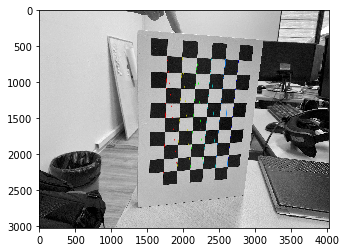

           calibration/chessboards/0.jpg... OK
[[ 8.04721199e-01 -8.54966056e+00  2.77373226e+03]
 [ 8.27322292e+00 -7.75413874e-01  6.96487171e+02]
 [ 5.86469429e-04 -5.94953683e-04  1.00000000e+00]]


In [98]:
corners_0, pattern_points_0 = processImage(img_names[0])
homography = cv2.findHomography(pattern_points_0, corners_0)[0]
print(homography)

## Warping
At the same way we did in undistorsion sometimes we know a mapping  (e.g homography)  between planar points (e.g. two images) and we would like to warp an image over another.

getPerspective
warpPerspective
 np.linalg.inv() 